Flight Price prediction using RandomForestRegressor


**1. Setting up the environment and libraries and loading our data**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
sns.set()

In [3]:
dataset = pd.read_excel("a1_FlightFare_Dataset.xlsx")

# To stretch head function output to the notebook width
pd.set_option('display.max_columns', None)

dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10001 non-null  object
 1   Date_of_Journey  10001 non-null  object
 2   Source           10001 non-null  object
 3   Destination      10001 non-null  object
 4   Route            10000 non-null  object
 5   Dep_Time         10001 non-null  object
 6   Arrival_Time     10001 non-null  object
 7   Duration         10001 non-null  object
 8   Total_Stops      10000 non-null  object
 9   Additional_Info  10001 non-null  object
 10  Price            10001 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 859.6+ KB


In [5]:
#To check if there are null values
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

We can see that there are barely any null values so we can just drop them rather than using various fillna methods

In [6]:
dataset.dropna(inplace = True)

**2. Feature Engineering**

In [7]:
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


**2.1 Handling object data**

* Date_of_Journey, Dep_Time, Arrival_Time, Duration are object datatype. To derive numeric features on these, we use pandas to_datetime method to convert object data type to datetime datatype.

-Attribute .dt.day will extract day from the date

-Attribute .dt.month will extract month from that date

-The year value is not extracted as in this dataset, all data is of 2019 so it will be of no value for predictions.

In [8]:
# Date_of_Journey is the day when plane departs. 
dataset["journey_day"] = pd.to_datetime(dataset.Date_of_Journey, format="%d/%m/%Y").dt.day
dataset["journey_month"] = pd.to_datetime(dataset["Date_of_Journey"], format = "%d/%m/%Y").dt.month
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [9]:
# Now we can drop the Date_Of_Journey column as we have already extracted the information required
dataset.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [10]:
#We extract departing hours and minutes and then drop the original object data typed column
dataset["dep_hour"] = pd.to_datetime(dataset["Dep_Time"]).dt.hour

dataset["dep_min"] = pd.to_datetime(dataset["Dep_Time"]).dt.minute
dataset.drop(["Dep_Time"], axis = 1, inplace = True)

C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\1707306527.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset["dep_hour"] = pd.to_datetime(dataset["Dep_Time"]).dt.hour
C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\1707306527.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset["dep_min"] = pd.to_datetime(dataset["Dep_Time"]).dt.minute


In [11]:
#Same process carried out for arrival time

dataset["arrival_hour"] = pd.to_datetime(dataset["Arrival_Time"]).dt.hour
dataset["arrival_min"] = pd.to_datetime(dataset["Arrival_Time"]).dt.minute
dataset.drop(["Arrival_Time"], axis = 1, inplace = True)

C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\2949332614.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset["arrival_hour"] = pd.to_datetime(dataset["Arrival_Time"]).dt.hour
C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\2949332614.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset["arrival_min"] = pd.to_datetime(dataset["Arrival_Time"]).dt.minute


In [12]:
dataset.head(20)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35
5,SpiceJet,Kolkata,Banglore,CCU → BLR,2h 25m,non-stop,No info,3873,24,6,9,0,11,25
6,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,15h 30m,1 stop,In-flight meal not included,11087,12,3,18,55,10,25
7,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,21h 5m,1 stop,No info,22270,1,3,8,0,5,5
8,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,25h 30m,1 stop,In-flight meal not included,11087,12,3,8,55,10,25
9,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,7h 50m,1 stop,No info,8625,27,5,11,25,19,15


Now Duration given is pretty much the difference between Arrival and Departure time, It is represented in X hours and Y minutes, but for some flights, either only hour value or minutes value is given

*To process this and make it consistent, we loop through all duration values(convert it into list for easy access). We use split function and check if both components of time that is hours and minutes are present.

*If not, we add 0 minutes or 0 hours and later on make new columns Duration hours and duration minutes and store these new values, We can drop the old Duration column.

In [13]:
#making list
duration=list(dataset['Duration'])
#example is for index 2, no minutes info is there, so we need to add 0 minutes, same case for index 18 too
for i in range(len(duration)):
    if len(duration[i].split())!=2:
        if 'h' in duration[i]:
            duration[i]=duration[i].strip()+'0m'
        else:
            duration[i]='0h' + duration[i].strip()
            
            
            

In [14]:
#example on how to extract minutes data
print(duration[1].split('h')[1][:-1])

 25


Now, we make new columns duration_hours and duration_minutes and drop the original Duration column

In [15]:
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "h")[1][:-1]))  #extracting minutes element

# new columns added
dataset["Duration_hours"] = duration_hours
dataset["Duration_mins"] = duration_mins

# Drop Duration column from the dataset
dataset.drop(["Duration"], axis = 1, inplace = True)

dataset.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


**2.2 Handling Categorical data**

* Airline, Source, Destination, Route, Total_Stops, Additional_Info are all categorical. We can deal with such data in numerous ways but keeping it simple, we can use:
    OneHotEncoding for nominal data i.e unordered data
    LabelEncoder for ordinal data i.e ordered data



In [16]:
#1 Airline
dataset['Airline'].value_counts()

Airline
Jet Airways                          3598
IndiGo                               1927
Air India                            1633
Multiple carriers                    1129
SpiceJet                              769
Vistara                               447
Air Asia                              296
GoAir                                 179
Multiple carriers Premium economy      13
Jet Airways Business                    5
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

In [17]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding, We use 'Other' to specify the airlines which are few in number
Airline = dataset[["Airline"]] #df
Current_Airline_list=Airline['Airline'] #object
new=[]

for carrier in Current_Airline_list:
    if carrier in ['Jet Airways', 'IndiGo', 'Air India', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia']:
        new.append(carrier)
    else:
        new.append("Other")

Airline['Airline']=pd.DataFrame(new)
Airline['Airline'].value_counts()


C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\3944858873.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Airline['Airline']=pd.DataFrame(new)


Airline
Jet Airways          3598
IndiGo               1927
Air India            1632
Multiple carriers    1129
SpiceJet              769
Vistara               447
Air Asia              296
GoAir                 179
Other                  22
Name: count, dtype: int64

OneHotEncoding by using pd.getdummies

In [18]:
Airline = pd.get_dummies(Airline, drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara
0,False,False,True,False,False,False,False,False
1,True,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False
3,False,False,True,False,False,False,False,False
4,False,False,True,False,False,False,False,False


In [19]:
#2 Source
dataset['Source'].value_counts()

Source
Delhi       4257
Kolkata     2678
Banglore    2058
Mumbai       647
Chennai      360
Name: count, dtype: int64

In [20]:
#This is also nominal categorical data so we can use OneHotEncoding itself
Source=dataset[['Source']]
Source=pd.get_dummies(Source,drop_first=True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,False,False,False,False
1,False,False,True,False
2,False,True,False,False
3,False,False,True,False
4,False,False,False,False


In [21]:
#3 Destination
dataset['Destination'].value_counts()

Destination
Cochin       4257
Banglore     2678
Delhi        1191
New Delhi     867
Hyderabad     647
Kolkata       360
Name: count, dtype: int64

In [22]:
#Onehotencoding is done
Destination=dataset[['Destination']]
#We rename New Delhi to Delhi to match with source
Current_Destination_List = Destination['Destination']
New_Destination_List = []

for value in Current_Destination_List:
  if value in ['New Delhi']:
    New_Destination_List.append('Delhi')
  else:
    New_Destination_List.append(value)

Destination['Destination'] = pd.DataFrame(New_Destination_List)

# As Destination is Nominal Categorical data we will perform OneHotEncoding
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\1689619384.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Destination['Destination'] = pd.DataFrame(New_Destination_List)


,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,False,True,False,False
1,False,False,False,False
2,True,False,False,False
3,False,False,False,False
4,False,True,False,False


<Axes: ylabel='count'>

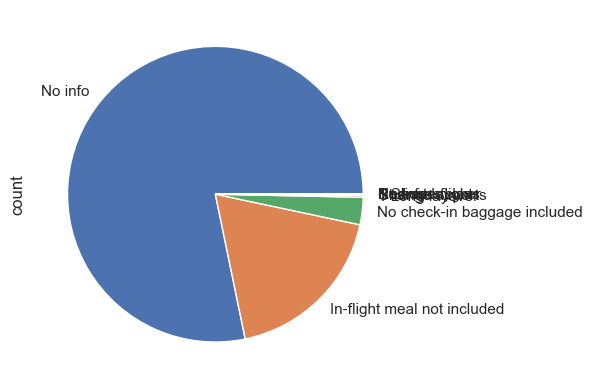

In [23]:
dataset['Additional_Info'].value_counts().plot(kind='pie')

* We see that a large amount of it is just No info, so we can just drop it as it won't contribute much towards our predictions
* Route is highly related to Total stops and it basically gives us the idea of how many stops the flight will make, it is easier to preprocess and use total stops as a independent variable rather than using route, so we drop it too

In [24]:
dataset.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [25]:
#4 Total_stops
dataset['Total_Stops'].value_counts()

Total_Stops
1 stop      5281
non-stop    3259
2 stops     1415
3 stops       44
4 stops        1
Name: count, dtype: int64

This is ordinal data as there is a order or we can basically rank them as well by number of stops. Thus, LabelEncoder can be used rather than onehotencoding as we can use integers to maintain a sense of heirarchy amongst the values of this categorical data.

In [26]:
dataset.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
dataset.head()

,Airline,Source,Destination,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [27]:
# Concatenate dataframe --> train_data + Airline + Source + Destination
data_train = pd.concat([dataset, Airline.astype(int), Source.astype(int), Destination.astype(int)], axis = 1) # axis = 1 signifies column
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

data_train.head()

,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
data_train.shape

(10000, 26)

**3 Feature Selection**

There are 25 features or independent variables for training but we need not use so many of them.
Reasons: 1 Not all features will have acceptable correlation with target variable i.e Price,
         2 Some features might be highly correlated with one another leading to a problem called multicollinearity.

We use 
* feature_importance to check and select highly correlated features and essentially choose important features
* VIF or Variable Inflation Factor to check for multicollinearity.

In [29]:
X = data_train.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
y = data_train.iloc[:, 1]

print(X.shape, y.shape)

(10000, 25) (10000,)


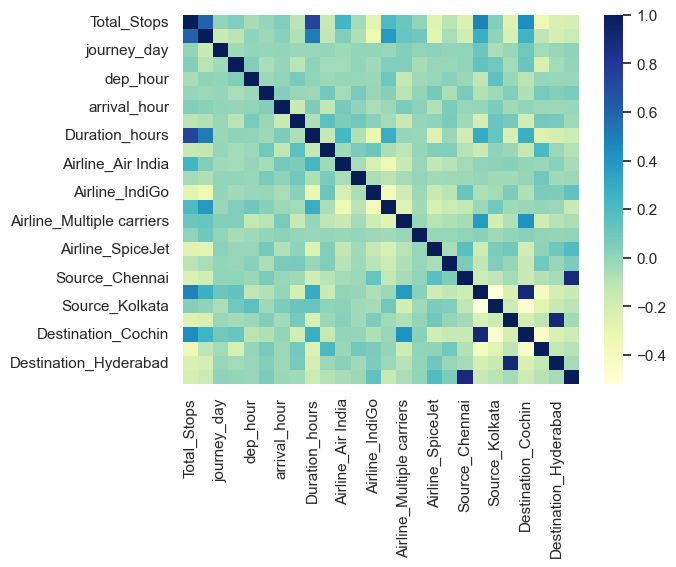

In [30]:
sns.heatmap(data_train.corr(),cmap='YlGnBu',annot=False)
plt.show()

It is difficult to infer from the correlation heatmap so we are going to use ExtraTreesRegressor and figure out the importance of features in our training dataset

*1 feature_importance*

In [31]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

print(selection.feature_importances_)

[0.23165559 0.14131275 0.06566032 0.02882181 0.02421128 0.03362496
 0.02525941 0.1446295  0.02073791 0.00804807 0.00133815 0.01106073
 0.11711874 0.01939719 0.02559688 0.00409358 0.00344978 0.00135397
 0.02383076 0.01077622 0.01576748 0.006811   0.02995972 0.00386555
 0.00161866]


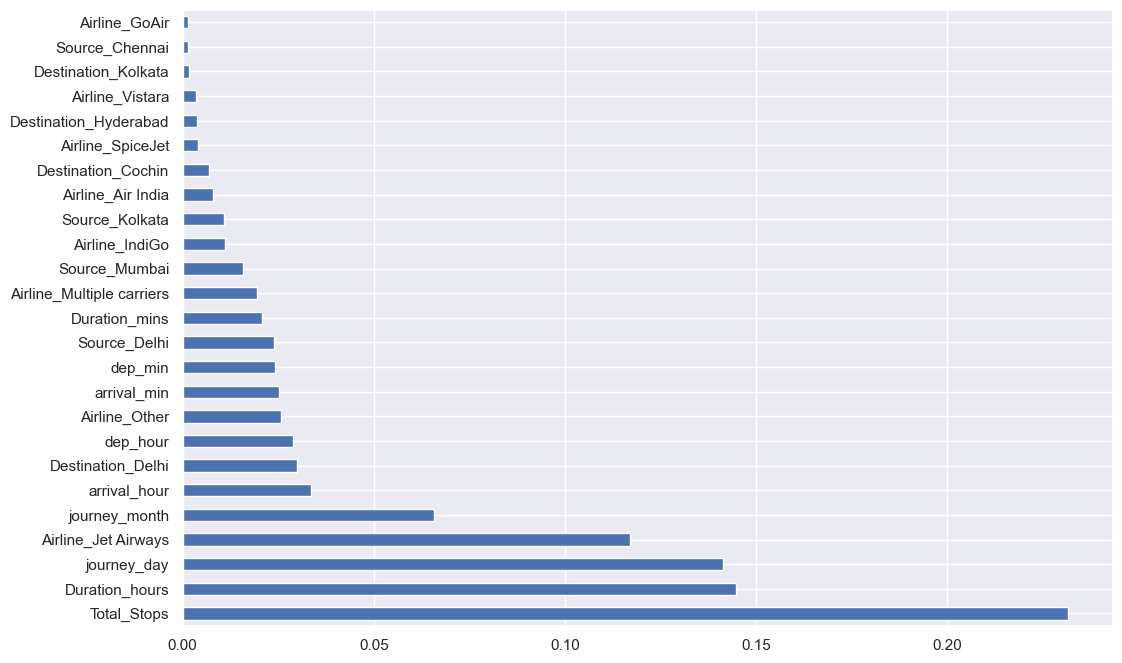

In [32]:
#plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

*2 VIF- Multicollinearity*

In [33]:
X.columns

Index(['Total_Stops', 'journey_day', 'journey_month', 'dep_hour', 'dep_min',
       'arrival_hour', 'arrival_min', 'Duration_hours', 'Duration_mins',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata'],
      dtype='object')

In [34]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif['VIF'] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

In [35]:
calc_vif(X)

,variables,VIF
0,Total_Stops,7.533035
1,journey_day,3.511805
2,journey_month,16.470796
3,dep_hour,5.790951
4,dep_min,2.804206
5,arrival_hour,4.923106
6,arrival_min,3.455823
7,Duration_hours,6.183394
8,Duration_mins,4.106901
9,Airline_Air India,5.381726


We see that VIF is greater than 10 for 2 journey month , 12 Airline jet_Airways ,18 Source_Delhi 21 Destination Cochin

Now seeing feature importance, we see Source Delhi is not that important and it has the highest VIF,so we can drop it,
* There are multiple ways to do this step as we can drop something else or  drop all.

This is a Feature importance-VIF tradeoff., For now i decided to just drop Source_Delhi

In [36]:
# Drop 'Source_Delhi'
X = data_train.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
X.head()

,Total_Stops,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


**4 Model Fitting**

In [37]:
#do train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Model selection, training and hyperparameter tuning for best model**

Choosing the right model is not always easy and can always vary in results due the nature of data
or hyperparameters used. I decided to use the most common models, and choose the best model based off of r2_score
which is a reputable metric.

I will further refine results by using Hyperparameter tuning by doing GridSearch which will kind of brute force all sorts of
hyperparameter configurations.

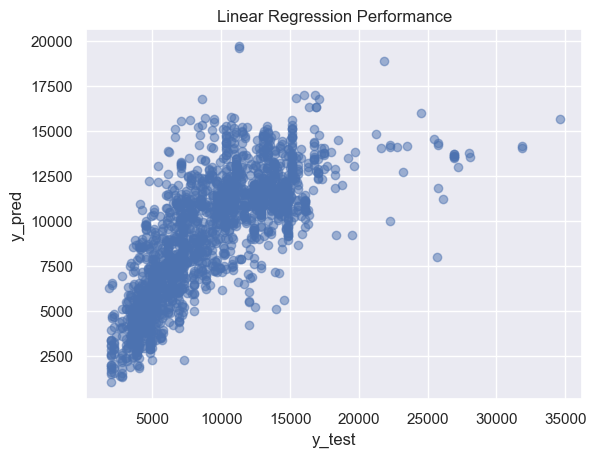

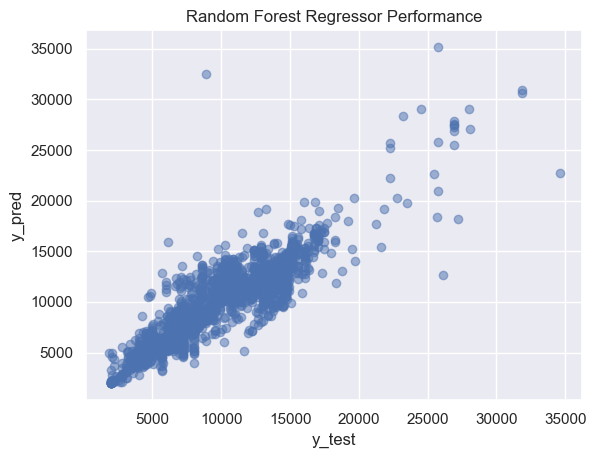

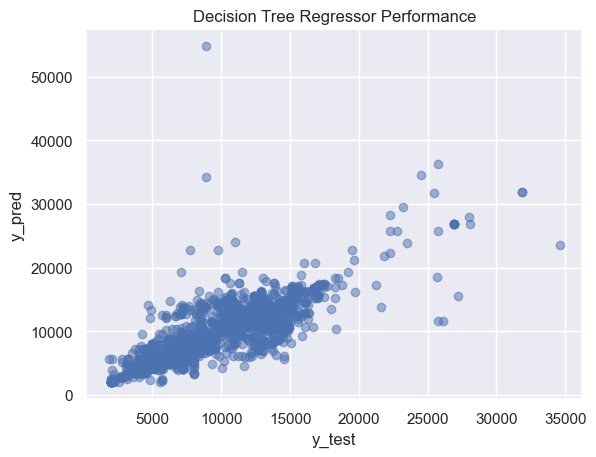

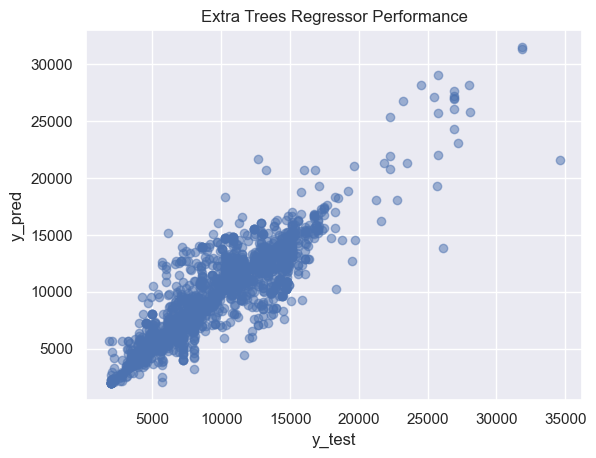

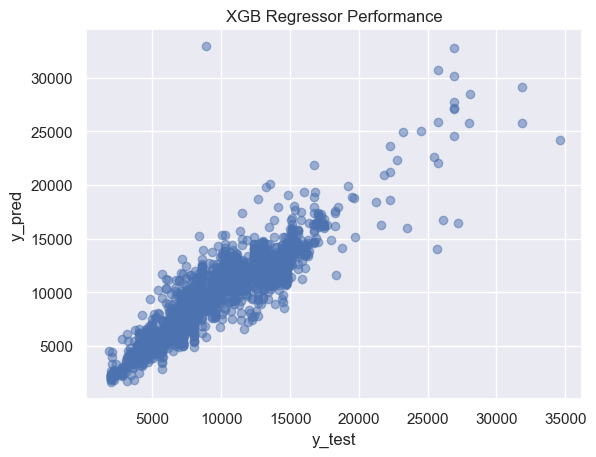

Best Model based on R2 Score: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Best model saved as best_model_no_tuning.pkl
Model                     MAE             MSE             RMSE            R2 Score (%)   
Linear Regression         2079.08         8509951.50      2917.18         57.16         

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle

# Define a function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred) * 100
    
    return mae, mse, rmse, r2

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Extra Trees Regressor': ExtraTreesRegressor(),
    'XGB Regressor': XGBRegressor()
}

# Evaluate each model and store the results
results = {}
for name, model in models.items():
    mae, mse, rmse, r2 = evaluate_model(model, X_train, X_test, Y_train, Y_test)
    results[name] = [mae, mse, rmse, r2]
    
    # Plot performance graph
    plt.scatter(Y_test, model.predict(X_test), alpha=0.5)
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.title(f"{name} Performance")
    plt.show()

# Find the best model based on R2 score
best_model_notunes = max(results, key=lambda k: results[k][3])
best_model_notune = models[best_model_notunes]
print(f"Best Model based on R2 Score: {best_model_notune}")

# Save the best  model which had no tuning using pickle
filename = 'best_model_no_tuning.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model_notune, file)

print(f"Best model saved as {filename}")

#making a comparitive table
print(f"{'Model':<25} {'MAE':<15} {'MSE':<15} {'RMSE':<15} {'R2 Score (%)':<15}")
print("="*90)
for name, metrics in results.items():
    print(f"{name:<25} {metrics[0]:<15.2f} {metrics[1]:<15.2f} {metrics[2]:<15.2f} {metrics[3]:<15.2f}")


**Hyperparameter Tuning**

Lets try to improve XGBRegressor results as that has the maximum r2_score

In [43]:
from sklearn.model_selection import GridSearchCV
xgb = XGBRegressor()


In [47]:
#standard syntax for gridsearch for xgb
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3,0.08,0.07],  
    'max_depth': [3, 4, 5,6,7,8],          
    'min_child_weight': [1, 3, 5,7,9],     
    'gamma': [0.0, 0.1, 0.2,0.3],          
    'colsample_bytree': [0.6, 0.8, 1.0,1.2] 
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)


In [48]:
grid_search.fit(X_train, Y_train)


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


C:\Users\NAVEEN\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3000 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\NAVEEN\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\NAVEEN\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\NAVEEN\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
  File "C:\Users\NAVEE

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0, 1.2],
                         'gamma': [0.0, 0.1, 0.2, 0.3],
                         'learning_rate': [0.1, 0.2, 0.3, 0.08, 0.07],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 5, 7, 9]},
             scoring='r2', verbose=1)

In [49]:
print("Best Parameters found:")
print(grid_search.best_params_)
print("Best R2 Score found:", grid_search.best_score_)

Best Parameters found:
{'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1}
Best R2 Score found: 0.7927581031318816


We see that a lot more searching is required which will take a lot of computing power, so i decided to use the initial xgb model itself

In [53]:
# Get the best model from grid search
best_xgb_model = xgb
best_xgb_model.fit(X_train,Y_train)

# Predict on the test set with the best model
y_pred_best = best_xgb_model.predict(X_test)



In [54]:
# Calculate and print the R2 score on the test set
r2 = r2_score(Y_test, y_pred_best)
print(f"R2 Score on Test Set with Best XGB Model: {r2}")

R2 Score on Test Set with Best XGB Model: 0.8397159288405414


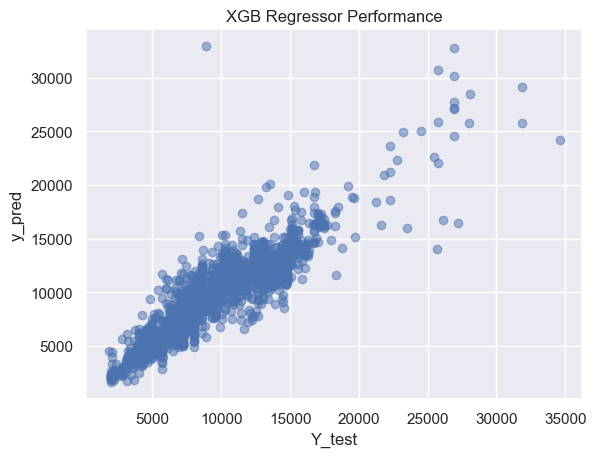

In [55]:
plt.scatter(Y_test, y_pred_best,alpha=0.5)
plt.xlabel("Y_test")
plt.ylabel("y_pred")
plt.title(f"{name} Performance")
plt.show()

In [56]:
#saving our tuned model
filename = 'best_model_final.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_xgb_model, file)

print(f"Best model saved as {filename}")

Best model saved as best_model_final.pkl


**Prediction on unseen data with best model**

In [58]:
import pickle
path = 'best_model_final.pkl'
model = open(path,'rb')
xg_model = pickle.load(model)

In [59]:
unseen_dataset = pd.read_excel("a2_Unseen_Dataset.xlsx")
unseen_dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,27/05/2019,Delhi,Cochin,DEL → BOM → COK,07:05,19:00,11h 55m,1 stop,In-flight meal not included,12898
1,IndiGo,6/03/2019,Delhi,Cochin,DEL → MAA → COK,02:05,07:25,5h 20m,1 stop,No info,10851
2,Air India,21/03/2019,Delhi,Cochin,DEL → BLR → COK,09:45,23:00,13h 15m,1 stop,No info,5704
3,Vistara,18/03/2019,Banglore,New Delhi,BLR → DEL,21:10,00:05 16 Mar,2h 55m,non-stop,No info,11598
4,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,08:30,19:15,10h 45m,1 stop,No info,9149


Perform the same preprocessing steps


In [60]:
# Perform feature engineering on object dt variables
# Feature Engineering on: 'Date_of_Journey'
unseen_dataset["journey_day"] = pd.to_datetime(unseen_dataset.Date_of_Journey, format="%d/%m/%Y").dt.day
unseen_dataset["journey_month"] = pd.to_datetime(unseen_dataset["Date_of_Journey"], format = "%d/%m/%Y").dt.month
unseen_dataset.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Feature Engineering on: 'Dep_Time'
unseen_dataset["dep_hour"] = pd.to_datetime(unseen_dataset["Dep_Time"]).dt.hour
unseen_dataset["dep_min"] = pd.to_datetime(unseen_dataset["Dep_Time"]).dt.minute
unseen_dataset.drop(["Dep_Time"], axis = 1, inplace = True)

# Feature Engineering on: 'Arrival_Time'
unseen_dataset["arrival_hour"] = pd.to_datetime(unseen_dataset["Arrival_Time"]).dt.hour
unseen_dataset["arrival_min"] = pd.to_datetime(unseen_dataset["Arrival_Time"]).dt.minute
unseen_dataset.drop(["Arrival_Time"], axis = 1, inplace = True)

# Feature Engineering on: 'Duration'
duration = list(unseen_dataset["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + "0m"   # Adds 0 minute
        else:
            duration[i] = "0h" + duration[i]           # Adds 0 hour
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "h")[1][:-1]))  #extracting minutes element

unseen_dataset["Duration_hours"] = duration_hours
unseen_dataset["Duration_mins"] = duration_mins
unseen_dataset.drop(["Duration"], axis = 1, inplace = True)


# Perform feature engineering on Categorical dt variables
# Feature Engineering on: 'Airline'
Airline = unseen_dataset[["Airline"]]
New_Airline_List = []
Current_Airline_List = Airline['Airline']
for carrier in Current_Airline_List:
  if carrier in ['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia']:
    New_Airline_List.append(carrier)
  else:
    New_Airline_List.append('Other')
Airline['Airline'] = pd.DataFrame(New_Airline_List)
Airline = pd.get_dummies(Airline, drop_first= True)

# Feature Engineering on: 'Source'
Source = unseen_dataset[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)
Source.head()

# Feature Engineering on: 'Destination'
Destination = unseen_dataset[["Destination"]]
Current_Destination_List = Destination['Destination']
New_Destination_List = []
for value in Current_Destination_List:
  if value in ['New Delhi']:
    New_Destination_List.append('Delhi')
  else:
    New_Destination_List.append(value)
Destination['Destination'] = pd.DataFrame(New_Destination_List)
Destination['Destination'].value_counts()
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

# Feature Engineering on: 'Route', 'Additional_Info
unseen_dataset.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Feature Engineering on: 'Total_Stops'
unseen_dataset.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> train_data + Airline + Source + Destination
data_test = pd.concat([unseen_dataset, Airline.astype(int), Source.astype(int), Destination.astype(int)], axis = 1)
data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

# See how the test dataset looks
data_test.head()

C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\2803885544.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unseen_dataset["dep_hour"] = pd.to_datetime(unseen_dataset["Dep_Time"]).dt.hour
C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\2803885544.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unseen_dataset["dep_min"] = pd.to_datetime(unseen_dataset["Dep_Time"]).dt.minute
C:\Users\NAVEEN\AppData\Local\Temp\ipykernel_24732\2803885544.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unseen_dataset["arrival_hour"] = pd.to_datetime(unseen_dataset["Arrival_Time

,Total_Stops,Price,journey_day,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Other,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,1,12898,27,5,7,5,19,0,11,55,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1,1,10851,6,3,2,5,7,25,5,20,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,5704,21,3,9,45,23,0,13,15,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,11598,18,3,21,10,0,5,2,55,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,1,9149,27,5,8,30,19,15,10,45,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [61]:
# Drop 'Source_Delhi'
X_unseen = data_test.loc[:, ['Total_Stops', 'journey_day', 'journey_month', 'dep_hour',
       'dep_min', 'arrival_hour', 'arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Other',
       'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']]
y_unseen = data_test.iloc[:, 1]

In [62]:
# Predictions on unseen data
y_pred = xg_model.predict(X_unseen)

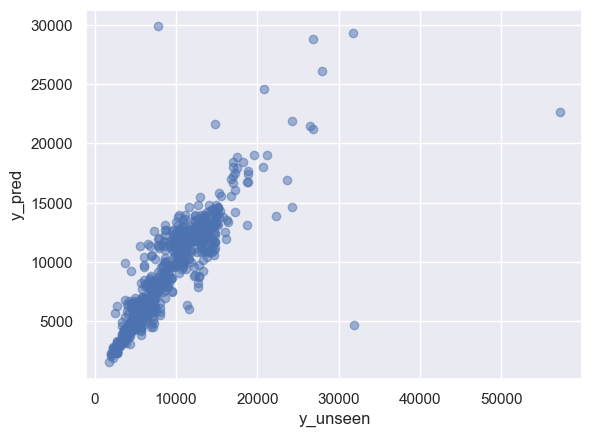

In [63]:
# Plot performance graph
plt.scatter(y_unseen, y_pred, alpha = 0.5)
plt.xlabel("y_unseen")
plt.ylabel("y_pred")
plt.show()

Decent predictions except for a few outliers

In [64]:
r=r2_score(y_unseen,y_pred)
print(f"R2 score on unseen data is {r}")


R2 score on unseen data is 0.7297960577554004


In [65]:
# writing model output file
df_y_pred = pd.DataFrame(y_pred,columns= ['Predicted Price'])
original_dataset = pd.read_excel("a2_Unseen_Dataset.xlsx")
dfx = pd.concat([original_dataset, df_y_pred], axis=1)
dfx.to_excel("ModelOutputonunseendata.xlsx")


In [66]:
dfx.head(50)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Predicted Price
0,Jet Airways,27/05/2019,Delhi,Cochin,DEL → BOM → COK,07:05,19:00,11h 55m,1 stop,In-flight meal not included,12898,15523.757812
1,IndiGo,6/03/2019,Delhi,Cochin,DEL → MAA → COK,02:05,07:25,5h 20m,1 stop,No info,10851,9559.475586
2,Air India,21/03/2019,Delhi,Cochin,DEL → BLR → COK,09:45,23:00,13h 15m,1 stop,No info,5704,8236.115234
3,Vistara,18/03/2019,Banglore,New Delhi,BLR → DEL,21:10,00:05 16 Mar,2h 55m,non-stop,No info,11598,6067.002441
4,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,08:30,19:15,10h 45m,1 stop,No info,9149,8977.363281
5,Air India,15/06/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145,4707.164551
6,GoAir,21/05/2019,Delhi,Cochin,DEL → BOM → COK,10:35,19:35,9h,1 stop,No info,6195,6410.260742
7,IndiGo,9/05/2019,Delhi,Cochin,DEL → BOM → COK,11:25,21:00,9h 35m,1 stop,No info,6979,7666.242188
8,Air India,15/03/2019,Banglore,New Delhi,BLR → DEL,13:20,16:10,2h 50m,non-stop,No info,7276,6808.797363
9,SpiceJet,15/05/2019,Delhi,Cochin,DEL → PNQ → COK,08:45,13:15,4h 30m,1 stop,No check-in baggage included,4760,5703.422363
